# Do not overfit -- Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score

In [2]:
data_path = 'data/'
train_data = pd.read_csv(f'{data_path}train.csv', index_col = 'id')
test_data = pd.read_csv(f'{data_path}test.csv', index_col = 'id')

In [3]:
corrs = train_data.drop(labels = ['target'], axis = 1).corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
89690,79,187,0.243916
89691,187,79,0.243916
89692,140,187,0.244012
89693,187,140,0.244012
89694,28,22,0.246062
89695,22,28,0.246062
89696,193,101,0.252825
89697,101,193,0.252825
89698,32,75,0.259315
89699,75,32,0.259315


In [4]:
train_data['target'].value_counts()

1.0    160
0.0     90
Name: target, dtype: int64

In [5]:
columns_impact = pd.DataFrame(
    columns = ['column_name', 'mean_impact_on_0', 'mean_impact_on_1', 'std_0', 'std_1']
)
for col in train_data.columns[train_data.columns != 'target']:
    columns_impact = columns_impact.append(dict(
        column_name = col
        , mean_impact_on_0 = train_data[train_data['target'] == 0][col].mean()
        , mean_impact_on_1 = train_data[train_data['target'] == 1][col].mean()
        , std_0 = train_data[train_data['target'] == 0][col].std()
        , std_1 = train_data[train_data['target'] == 1][col].std()
    )
                                          , ignore_index = True)

In [6]:
columns_impact['upper_l_0'] = columns_impact['mean_impact_on_0'] + 1.96 * columns_impact['std_0']
columns_impact['upper_l_1'] = columns_impact['mean_impact_on_1'] + 1.96 * columns_impact['std_1']
columns_impact['lower_l_0'] = columns_impact['mean_impact_on_0'] - 1.96 * columns_impact['std_0']
columns_impact['lower_l_1'] = columns_impact['mean_impact_on_1'] - 1.96 * columns_impact['std_1']
columns_impact['overlap'] = columns_impact.apply(
lambda row: min(row['upper_l_0'], row['upper_l_1']) - max(row['lower_l_0'], row['lower_l_1'])
    , axis = 1
)
columns_impact['spread'] = columns_impact.apply(
lambda row: max(row['upper_l_0'], row['upper_l_1']) - min(row['lower_l_0'], row['lower_l_1'])
    , axis = 1
)
columns_impact['opportunity'] = columns_impact['spread'] - columns_impact['overlap']
columns_impact['oppor_factor'] = columns_impact.apply(
lambda row: 0 if (((row['upper_l_0'] > row['upper_l_1']) and (row['lower_l_0'] < row['lower_l_1']))
    or ((row['upper_l_0'] < row['upper_l_1']) and (row['lower_l_0'] > row['lower_l_1']))) else 1
    , axis = 1
)
columns_impact['opportunity'] = columns_impact['opportunity'] * columns_impact['oppor_factor']

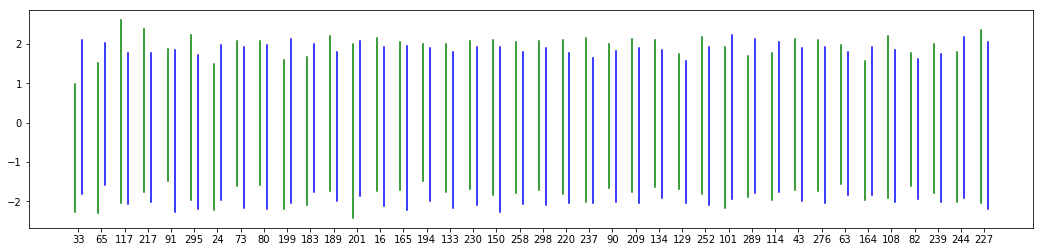

In [7]:
columns_impact = columns_impact.sort_values(by=['opportunity'], ascending = [False])

plt.figure(figsize=(18,4))
for num, col in enumerate(columns_impact['column_name'][:40]):
    plt.plot([num-0.15, num-0.15], [columns_impact[columns_impact['column_name'] == col].loc[int(col), 'upper_l_0']
                                    , columns_impact[columns_impact['column_name'] == col].loc[int(col), 'lower_l_0']], 'g')
    plt.plot([num+0.15, num+0.15], [columns_impact[columns_impact['column_name'] == col].loc[int(col), 'upper_l_1']
                                    , columns_impact[columns_impact['column_name'] == col].loc[int(col), 'lower_l_1']], 'b')
plt.xticks(np.arange(num + 1), list(columns_impact['column_name']))
plt.show()

In [8]:
best_columns = list(
    columns_impact['column_name'][:50]
)
train_data = train_data[best_columns + ['target']]
train_data.head()

,33,65,117,217,91,295,24,73,80,199,...,105,127,98,89,180,119,151,156,281,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.385,-0.770,0.710,1.187,0.019,-2.097,1.763,-2.464,1.851,1.716,...,0.158,-1.366,-1.556,1.420,0.030,1.920,0.671,-0.607,1.253,1.0
1,-2.721,1.221,0.987,0.216,1.188,-1.624,-1.519,-1.190,-0.759,-2.414,...,-0.475,-0.625,-0.305,-1.822,0.643,-0.373,-1.382,-0.075,-0.307,0.0
2,0.924,0.943,-0.384,0.269,0.269,-1.165,1.786,1.910,0.758,0.288,...,0.208,-0.517,0.074,-1.488,-1.710,0.098,0.388,-0.657,0.037,1.0
3,0.394,-0.706,-0.152,0.066,1.103,0.467,0.365,0.606,0.030,1.089,...,0.764,1.077,-2.284,1.188,-0.482,-0.985,0.223,0.492,0.322,1.0
4,0.037,0.357,1.027,0.110,0.892,1.378,0.024,-0.937,-0.187,0.084,...,0.689,-1.474,0.749,0.218,0.842,1.037,-1.302,1.409,1.408,1.0


In [9]:
train_X, val_X, train_y, val_y = train_test_split(
    train_data[train_data.columns[train_data.columns != 'target']]
    , train_data['target']
    , random_state = 1
    , test_size = 0.2
)

cl_log = LogisticRegression()
cl_log.fit(train_X, train_y)

yhat = cl_log.predict_proba(val_X)[:, 1]

# calculate aucroc
aucroc = roc_auc_score(val_y, yhat)

print('aucroc=%.3f' % aucroc)

aucroc=0.897


In [10]:
cl_log_final = LogisticRegression()
cl_log_final.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])
test_yhat = cl_log_final.predict_proba(test_data[train_data.columns[train_data.columns != 'target']])[:, 1]
submission_df = pd.DataFrame({'target' : test_yhat}, index = test_data.index)

In [11]:
submission_df.to_csv(f'{data_path}logreg_basic.csv', sep = ',')

In [12]:
my_folds = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10, random_state = 2)

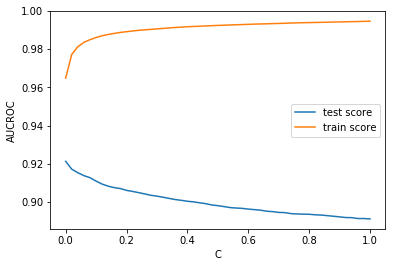

In [13]:
C = np.linspace(start = 0.0001, stop = 1, num=51)
hyperparameters = dict(C = C)
cl_log = LogisticRegression(penalty = 'l2', max_iter = 100)
grid_logl2 = GridSearchCV(cl_log
                        , hyperparameters
                        , cv = my_folds
                        , verbose = 0
                        , scoring = 'roc_auc'
                        , return_train_score = True)
grid_logl2.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])

test_scores = grid_logl2.cv_results_['mean_test_score']
train_scores = grid_logl2.cv_results_['mean_train_score']
param_C = grid_logl2.cv_results_['param_C']
plt.plot(param_C, test_scores, label = 'test score')
plt.plot(param_C, train_scores, label = 'train score')
plt.xlabel('C')
plt.ylabel('AUCROC')
plt.legend()
plt.show()

In [14]:
print('The best value of C:  ' +
      "{:.5f}".format(grid_logl2.best_params_['C']) +
      '\nThe best AUCROC score:  ' +
      "{:.3f}".format(grid_logl2.best_score_)
     )

The best value of C:  0.00010
The best AUCROC score:  0.921


In [15]:
cl_log_final = LogisticRegression(
    penalty = 'l2'
    , max_iter = 100
    , C = 0.0001
)
cl_log_final.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])
test_yhat = cl_log_final.predict_proba(test_data[train_data.columns[train_data.columns != 'target']])[:, 1]
submission_df = pd.DataFrame({'target' : test_yhat}, index = test_data.index)
submission_df.to_csv(f'{data_path}logreg_tunedl2.csv', sep = ',')

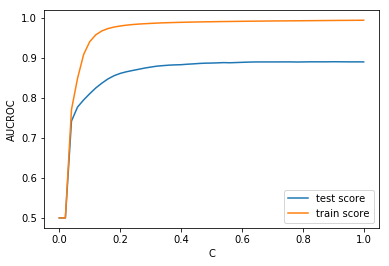

In [16]:
C = np.linspace(start = 0.0001, stop = 1, num=51)
hyperparameters = dict(C = C)
cl_log = LogisticRegression(penalty = 'l1', max_iter = 100)
grid_logl1 = GridSearchCV(cl_log
                        , hyperparameters
                        , cv = my_folds
                        , verbose = 0
                        , scoring = 'roc_auc'
                        , return_train_score = True)
grid_logl1.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])

test_scores = grid_logl1.cv_results_['mean_test_score']
train_scores = grid_logl1.cv_results_['mean_train_score']
param_C = grid_logl1.cv_results_['param_C']
plt.plot(param_C, test_scores, label = 'test score')
plt.plot(param_C, train_scores, label = 'train score')
plt.xlabel('C')
plt.ylabel('AUCROC')
plt.legend()
plt.show()

In [17]:
print('The best value of C:  ' +
      "{:.5f}".format(grid_logl1.best_params_['C']) +
      '\nThe best AUCROC score:  ' +
      "{:.3f}".format(grid_logl1.best_score_)
     )

The best value of C:  0.90001
The best AUCROC score:  0.890


In [18]:
cl_log_final = LogisticRegression(
    penalty = 'l1'
    , max_iter = 100
    , C = 0.90001
)
cl_log_final.fit(train_data[train_data.columns[train_data.columns != 'target']], train_data['target'])
test_yhat = cl_log_final.predict_proba(test_data[train_data.columns[train_data.columns != 'target']])[:, 1]
submission_df = pd.DataFrame({'target' : test_yhat}, index = test_data.index)
submission_df.to_csv(f'{data_path}logreg_tunedl1.csv', sep = ',')